# Assignment 2 - Object Detection | Semantic Segmentation

This notebook contains the required task for the second assignment of the Software for Advanced Machine Learning course. Read the task description and implement the empty code cells. Each section represents a stage along implementing your task [Object Detection or Semantic Segmantation], from loading and inspecting the dataset to testing a **pre-trained** model. The sections are to guide you but you do not have to follow that specific order. 

Copy this notebook to your drive (File -> Save a copy in Drive), edit it and upload the final ipynb file to [Canvas](https://canvas.elte.hu) or upload the link to the Colab notebook itself. If you have your own machine with Jupyter installed, you can work there as well.

**Note** Make sure the notebook is using GPU accelerataion in Edit -> Notebook settings, otherwise inference can be very slow.

## Rules and Comments
- From the list of datasets and tasks listed in canvas, each student was atributed **1 task and 1 dataset** to use within this assignment. Please confirm yours in the Canvas assignment's description. 
- The emphasis of this assignment is put in the way you use and compare the different models. The metrics you present are very important.
- As always, copying others' code will make you fail the homework automatically (and thus the course). 
- **Deadline is April 24**
- Make sure your code can be run from an empty state (use Runtime -> Run all in the menu after restarting the notebook)
- Feel free to add more code cells as needed. But don't put code into external Python files to ease the reviewing.
- Please add your name and Neptun ID below for easier identification.

**Name: Viktor Habony**  
**Neptun ID: H8SCMR** 

## Task description
Given your task (Semantic Segmentation or Object Detection), you have to test three (3) pretrained models on the test set of a given dataset, comparing the results between the models. For the comparison, you have to use at least three (3) metrics commonly used in your task.

For example, if student A is given Object Detection task and the Ballons v2 dataset, then his/her task is to choose 3 pretrained object detection models [R-CNN, YOLO, ...] and evaluate them on the Ballons v2 test set, comparing the results using 3 metrics [mAP, Recall, ...]. If a dataset does not have a testing set, then the student should split at least 10% of the training set to create the test set.

For running test/evaluation/inference on a pre-trained model, it is important to know what are the model requirements, so that the input is preprocessed accordingly.
Make sure to explore the data and **present detailed evaluation metrics**.

**Please answer the questions.**



## 0. Import libraries
Import all libraries/packages that you believe will help you fulfil the task, but **for the network only PyTorch can be used.**

In [1]:
# ADD YOUR CODE HERE


from torchvision.datasets.utils import download_url
from torch.utils.data import Dataset
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import InterpolationMode

from PIL import Image

import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
%matplotlib inline

import tarfile
import os
import cv2
import numpy as np
import random
import shutil
import seaborn as sns

## 1. Dataset 
Load the dataset you were given. If your data does not have a test set, split a portion of your training set (at least 10%).
Explore the dataset by visualizing the images and annotations.


#### Loading the dataset


In [2]:
# ADD YOUR CODE HERE

download_url('https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz', '.')

  0%|          | 0/811706944 [00:00<?, ?it/s]

In [3]:
with tarfile.open('./oxford-iiit-pet.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

#### Helper functions for:
 - get the image category
 - open images
 - denormalize images
 - show the image
 - display images with the grand truth mask (optinal: predicted mask)
 - preprocessing the grand truth mask
 - postprocessing the predicted mask

In [4]:
def parse_breed(fname):
    parts = fname.split('_')
    return ' '.join(parts[:-1])

def open_image(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')
    
def denormalize(images, means, stds):
    
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
        
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds  = torch.tensor(stds).reshape(1, 3, 1, 1)
    
    return images * stds + means
    
def show_image(img_tensor):

    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)
    
def display_image_grid(orig_images, gt_masks, labels, images_num, predictions = None):
    
    cols = 3 if predictions is not None else 2
    rows = images_num
    
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 24))
    
    for i in range(images_num):

        gt_image       = convert_image(orig_images[i])
        gt_mask        = gt_masks[i]
        
        if predictions is not None:
            predicted_mask = predictions[i]
        
        ax[i, 0].imshow(gt_image)
        ax[i, 1].imshow(gt_mask, interpolation="nearest")

        ax[i, 0].set_title(labels[i])
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
        
        if predictions is not None: 
            ax[i, 2].imshow(predicted_mask, interpolation="nearest")
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()
        
    plt.tight_layout()
    plt.show()    
    
def convert_image(img_tensor):
    
    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
    
    return img_tensor

def preprocess_mask(mask):
    
    mask = mask.astype('uint8')
    mask[mask == 2] = 0
    mask[(mask == 1) | (mask == 3)] = 1
    
    return mask

def postprocess_predictions(predictions):
    
    for i in range(predictions.shape[0]):
    
        predictions[i] = predictions[i].astype('uint8')
        predictions[i][(predictions[i] != 12) & (predictions[i] != 8)] = 0
        predictions[i][(predictions[i] == 12) | (predictions[i] == 8)] = 1
        
    #predictions = torch.from_numpy(predictions)
    
    return predictions    

#### Class for the dataset loader

In [5]:
class PetsDataset(Dataset):
    
    def __init__(self, train_data, test_data, root, trimap_root, transform, size):
        
        super().__init__()
        
        self.train_data       = train_data
        self.test_data        = test_data
        self.directories      = [train_data, test_data]
        self.root             = root
        self.trimap_root      = trimap_root
        self.files            = [fname for fname in os.listdir(root) if fname.endswith('.jpg')]
        self.test_images      = []
        self.test_images_path = []
        self.classes          = list(set(parse_breed(fname) for fname in self.files))
        self.transform        = transform
        self.size             = size
        
        # Creating subfolders for the classes 
        for directory in self.directories:
            for current_class in self.classes:
                if(not os.path.exists(os.path.join(directory, current_class))):
                    os.makedirs(os.path.join(directory, current_class))
        
                
        i = 0

        # Copying all images to the train folder    
        for img in self.files:

            img_class  = parse_breed(img)
            
            s = shutil.copy(self.root + '/' + img, self.train_data + '/' + img_class + '/')

            if len(s) != 0:
                i += 1
                print("Copying the " + str(i) + ". image to the " + self.train_data + '/' + img_class + " directory")  
            else:
                print("Something went wrong with the " + self.root + '/' + img + ' image')
        
                
        cnt = 0

        # Copying 20% of the images to the test folder
        for current_class in self.classes:
            for img in os.listdir(self.train_data + '/' + current_class):

                length = int(len(os.listdir(self.train_data + '/' + current_class)) * 0.2)

                if cnt < length:
                    shutil.move(self.train_data + '/' + current_class + '/' + img, self.test_data + '/' + current_class + '/')
                    self.test_images.append(img)
                    self.test_images_path.append(self.test_data + '/' + current_class)
                    cnt += 1
            cnt = 0    
            
        # Creating subfolders for the classes 
        for directory in self.directories:
            for current_class in self.classes:
                if(os.path.exists(os.path.join(directory, current_class))):
                    os.makedirs(os.path.join(directory, current_class, 'trimaps'))    
                    
        for current_class in self.classes:
            trimaps_for_class = [fname for fname in os.listdir(self.test_data + '/' + current_class) if fname.endswith('.jpg')]
            
            for img in trimaps_for_class:
                
                
                s = shutil.copy(self.trimap_root + '/' + img[:-4] + '.png', self.test_data + '/' + current_class + '/trimaps/')

                if len(s) != 0:
                    i += 1
                    print("Copying the " + str(i) + ". image to the " + self.test_data + '/' + current_class + ' /trimaps' + 'directory')  
                else:
                    print("Something went wrong with the " + self.test_data + '/' + img + ' image')
                    
    
    def __len__(self):
        return len(self.test_images)

    def __getitem__(self, i):
        fname           = self.test_images[i]
        fpath           = self.test_images_path[i] #os.path.join(self.root, fname)
        img             = self.transform(open_image(fpath + '/' + fname))
        trimap_new_path = fpath + '/trimaps'
        trimap_img      = preprocess_mask(cv2.imread(os.path.join(trimap_new_path, fname.replace(".jpg", ".png")), cv2.IMREAD_UNCHANGED))
        trimap_img      = cv2.resize(trimap_img, (self.size, self.size))
        class_name      = parse_breed(fname)
        
        return img, trimap_img, class_name

#### Creating and pre-processing the dataset

In [6]:
# ADD YOUR CODE HERE


train_data     = './data/oxford-iiit-pet/train'
test_data      = './data/oxford-iiit-pet/test'
images_dir     = './data/oxford-iiit-pet/images'
trimap_dir     = './data/oxford-iiit-pet/annotations/trimaps'
img_size       = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

images_transformer = T.Compose([T.Resize([img_size, img_size]), 
                                #T.Pad(8, padding_mode='reflect'),
                                #T.RandomCrop(img_size), 
                                T.ToTensor(), 
                                T.Normalize(*imagenet_stats)])


test_data = PetsDataset(train_data, test_data, images_dir, trimap_dir, images_transformer, 224)

Copying the 1. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 2. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 3. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 4. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 5. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 6. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 7. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 8. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 9. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 10. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 11. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 12. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 13. image to the ./data/oxford-iiit-pet/train/Aby

Copying the 113. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 114. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 115. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 116. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 117. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 118. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 119. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 120. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 121. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 122. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 123. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 124. image to the ./data/oxford-iiit-pet/train/Abyssinian directory
Copying the 125. image to the ./data/oxf

Copying the 228. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 229. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 230. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 231. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 232. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 233. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 234. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 235. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 236. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 237. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 238. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 239. image to the ./data/oxford-iiit-pet/t

Copying the 336. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 337. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 338. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 339. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 340. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 341. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 342. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 343. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 344. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 345. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 346. image to the ./data/oxford-iiit-pet/train/american bulldog directory
Copying the 347. image to the ./data/oxford-iiit-pet/t

Copying the 444. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 445. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 446. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 447. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 448. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 449. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 450. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 451. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 452. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 453. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 454. image to the ./data/oxford-iiit-p

Copying the 556. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 557. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 558. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 559. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 560. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 561. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 562. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 563. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 564. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 565. image to the ./data/oxford-iiit-pet/train/american pit bull terrier directory
Copying the 566. image to the ./data/oxford-iiit-p

Copying the 657. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 658. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 659. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 660. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 661. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 662. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 663. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 664. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 665. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 666. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 667. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 668. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 669.

Copying the 765. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 766. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 767. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 768. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 769. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 770. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 771. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 772. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 773. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 774. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 775. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 776. image to the ./data/oxford-iiit-pet/train/basset hound directory
Copying the 777.

Copying the 917. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 918. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 919. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 920. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 921. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 922. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 923. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 924. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 925. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 926. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 927. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 928. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 929. image to the ./data/oxford-iiit-pet/train/beagle directory
Copying the 

Copying the 1030. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1031. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1032. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1033. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1034. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1035. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1036. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1037. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1038. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1039. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1040. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1041. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1042. image to the ./data/oxford-iiit-pet/train/Bengal directory

Copying the 1139. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1140. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1141. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1142. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1143. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1144. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1145. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1146. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1147. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1148. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1149. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1150. image to the ./data/oxford-iiit-pet/train/Bengal directory
Copying the 1151. image to the ./data/oxford-iiit-pet/train/Bengal directory

Copying the 1248. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1249. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1250. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1251. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1252. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1253. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1254. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1255. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1256. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1257. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1258. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1259. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1260. image to the ./data/oxford-iiit-pet/train/Birman directory

Copying the 1392. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1393. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1394. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1395. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1396. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1397. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1398. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1399. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1400. image to the ./data/oxford-iiit-pet/train/Birman directory
Copying the 1401. image to the ./data/oxford-iiit-pet/train/Bombay directory
Copying the 1402. image to the ./data/oxford-iiit-pet/train/Bombay directory
Copying the 1403. image to the ./data/oxford-iiit-pet/train/Bombay directory
Copying the 1404. image to the ./data/oxford-iiit-pet/train/Bombay directory

Copying the 1545. image to the ./data/oxford-iiit-pet/train/Bombay directory
Copying the 1546. image to the ./data/oxford-iiit-pet/train/Bombay directory
Copying the 1547. image to the ./data/oxford-iiit-pet/train/Bombay directory
Copying the 1548. image to the ./data/oxford-iiit-pet/train/Bombay directory
Copying the 1549. image to the ./data/oxford-iiit-pet/train/Bombay directory
Copying the 1550. image to the ./data/oxford-iiit-pet/train/Bombay directory
Copying the 1551. image to the ./data/oxford-iiit-pet/train/Bombay directory
Copying the 1552. image to the ./data/oxford-iiit-pet/train/Bombay directory
Copying the 1553. image to the ./data/oxford-iiit-pet/train/Bombay directory
Copying the 1554. image to the ./data/oxford-iiit-pet/train/Bombay directory
Copying the 1555. image to the ./data/oxford-iiit-pet/train/Bombay directory
Copying the 1556. image to the ./data/oxford-iiit-pet/train/Bombay directory
Copying the 1557. image to the ./data/oxford-iiit-pet/train/Bombay directory

Copying the 1694. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1695. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1696. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1697. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1698. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1699. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1700. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1701. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1702. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1703. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1704. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1705. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 1706. image to the ./data/oxford-iiit-pet/train/boxer directory
Copying the 

Copying the 1841. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1842. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1843. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1844. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1845. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1846. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1847. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1848. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1849. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1850. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1851. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1852. image to the .

Copying the 1945. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1946. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1947. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1948. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1949. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1950. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1951. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1952. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1953. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1954. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1955. image to the ./data/oxford-iiit-pet/train/British Shorthair directory
Copying the 1956. image to the .

Copying the 2050. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2051. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2052. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2053. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2054. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2055. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2056. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2057. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2058. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2059. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2060. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2061. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2062. image to the ./data/ox

Copying the 2153. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2154. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2155. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2156. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2157. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2158. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2159. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2160. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2161. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2162. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2163. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2164. image to the ./data/oxford-iiit-pet/train/chihuahua directory
Copying the 2165. image to the ./data/ox

Copying the 2255. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2256. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2257. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2258. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2259. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2260. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2261. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2262. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2263. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2264. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2265. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copying the 2266. image to the ./data/oxford-iiit-pet/train/Egyptian Mau directory
Copy

Copying the 2404. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2405. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2406. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2407. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2408. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2409. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2410. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2411. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2412. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2413. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2414. image to the ./data/oxford-iiit-pet/train/english co

Copying the 2502. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2503. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2504. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2505. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2506. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2507. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2508. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2509. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2510. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2511. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2512. image to the ./data/oxford-iiit-pet/train/english co

Copying the 2592. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2593. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2594. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2595. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2596. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2597. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2598. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2599. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2600. image to the ./data/oxford-iiit-pet/train/english cocker spaniel directory
Copying the 2601. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2602. image to the ./data/oxford-iiit-pet/train/english setter dir

Copying the 2705. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2706. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2707. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2708. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2709. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2710. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2711. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2712. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2713. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2714. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2715. image to the ./data/oxford-iiit-pet/train/english setter directory
Copying the 2716. image to the ./data/oxford-iiit-pet/train/engli

Copying the 2830. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2831. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2832. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2833. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2834. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2835. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2836. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2837. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2838. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2839. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2840. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2841. ima

Copying the 2960. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2961. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2962. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2963. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2964. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2965. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2966. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2967. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2968. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2969. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2970. image to the ./data/oxford-iiit-pet/train/german shorthaired directory
Copying the 2971. ima

Copying the 3091. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3092. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3093. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3094. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3095. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3096. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3097. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3098. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3099. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3100. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3101. image to the ./data/oxford-iiit-pet/train/great pyrenees directory
Copying the 3102. image to the ./data/oxford-iiit-pet/train/great

Copying the 3223. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3224. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3225. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3226. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3227. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3228. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3229. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3230. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3231. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3232. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3233. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3234. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3235. image to the ./data/oxford-iiit-pe

Copying the 3358. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3359. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3360. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3361. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3362. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3363. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3364. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3365. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3366. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3367. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3368. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3369. image to the ./data/oxford-iiit-pet/train/havanese directory
Copying the 3370. image to the ./data/oxford-iiit-pe

Copying the 3485. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3486. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3487. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3488. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3489. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3490. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3491. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3492. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3493. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3494. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3495. image to the ./data/oxford-iiit-pet/train/japanese chin directory
Copying the 3496. image to the ./data/oxford-iiit-pet/train/japanese chin di

Copying the 3631. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3632. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3633. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3634. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3635. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3636. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3637. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3638. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3639. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3640. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3641. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3642. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3643. image to the ./data/oxford-iiit-pe

Copying the 3774. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3775. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3776. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3777. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3778. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3779. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3780. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3781. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3782. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3783. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3784. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3785. image to the ./data/oxford-iiit-pet/train/keeshond directory
Copying the 3786. image to the ./data/oxford-iiit-pe

Copying the 3913. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3914. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3915. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3916. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3917. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3918. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3919. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3920. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3921. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3922. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3923. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3924. image to the ./data/oxford-iiit-pet/train/leonberger directory
Copying the 3925. image to t

Copying the 4054. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4055. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4056. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4057. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4058. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4059. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4060. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4061. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4062. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4063. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4064. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4065. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4066. image to t

Copying the 4176. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4177. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4178. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4179. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4180. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4181. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4182. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4183. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4184. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4185. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4186. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4187. image to the ./data/oxford-iiit-pet/train/Maine Coon directory
Copying the 4188. image to t

Copying the 4291. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4292. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4293. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4294. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4295. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4296. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4297. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4298. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4299. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4300. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4301. image to the ./data/oxford-iiit-pet/train/miniature pinscher directory
Copying the 4302. ima

Copying the 4412. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4413. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4414. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4415. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4416. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4417. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4418. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4419. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4420. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4421. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4422. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4423. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copy

Copying the 4537. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4538. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4539. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4540. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4541. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4542. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4543. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4544. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4545. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4546. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4547. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copying the 4548. image to the ./data/oxford-iiit-pet/train/newfoundland directory
Copy

Copying the 4656. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4657. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4658. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4659. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4660. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4661. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4662. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4663. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4664. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4665. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4666. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4667. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4668. image to the ./data/oxford-iiit-pet/train/Pers

Copying the 4773. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4774. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4775. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4776. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4777. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4778. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4779. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4780. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4781. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4782. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4783. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4784. image to the ./data/oxford-iiit-pet/train/Persian directory
Copying the 4785. image to the ./data/oxford-iiit-pet/train/Pers

Copying the 4886. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4887. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4888. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4889. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4890. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4891. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4892. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4893. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4894. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4895. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4896. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4897. image to the ./data/oxford-iiit-pet/train/pomeranian directory
Copying the 4898. image to t

Copying the 5001. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5002. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5003. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5004. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5005. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5006. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5007. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5008. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5009. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5010. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5011. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5012. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5013. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5014. image to the ./data/

Copying the 5145. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5146. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5147. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5148. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5149. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5150. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5151. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5152. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5153. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5154. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5155. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5156. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5157. image to the ./data/oxford-iiit-pet/train/pug directory
Copying the 5158. image to the ./data/

Copying the 5261. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5262. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5263. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5264. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5265. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5266. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5267. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5268. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5269. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5270. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5271. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5272. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5273. image to the ./data/oxford-iiit-pet/train/Ragd

Copying the 5399. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5400. image to the ./data/oxford-iiit-pet/train/Ragdoll directory
Copying the 5401. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5402. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5403. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5404. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5405. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5406. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5407. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5408. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5409. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5410. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 54

Copying the 5506. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5507. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5508. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5509. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5510. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5511. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5512. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5513. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5514. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5515. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5516. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copying the 5517. image to the ./data/oxford-iiit-pet/train/Russian Blue directory
Copy

Copying the 5614. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5615. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5616. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5617. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5618. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5619. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5620. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5621. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5622. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5623. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5624. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5625. image to the ./data/oxford-iiit-pet/train/saint bernard di

Copying the 5720. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5721. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5722. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5723. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5724. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5725. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5726. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5727. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5728. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5729. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5730. image to the ./data/oxford-iiit-pet/train/saint bernard directory
Copying the 5731. image to the ./data/oxford-iiit-pet/train/saint bernard di

Copying the 5833. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5834. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5835. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5836. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5837. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5838. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5839. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5840. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5841. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5842. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5843. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5844. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5845. image to the ./data/oxford-iiit-pet/train/samo

Copying the 5945. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5946. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5947. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5948. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5949. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5950. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5951. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5952. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5953. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5954. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5955. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5956. image to the ./data/oxford-iiit-pet/train/samoyed directory
Copying the 5957. image to the ./data/oxford-iiit-pet/train/samo

Copying the 6053. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6054. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6055. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6056. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6057. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6058. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6059. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6060. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6061. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6062. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6063. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6064. image to the ./data/oxfor

Copying the 6159. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6160. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6161. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6162. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6163. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6164. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6165. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6166. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6167. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6168. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6169. image to the ./data/oxford-iiit-pet/train/scottish terrier directory
Copying the 6170. image to the ./data/oxfor

Copying the 6275. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6276. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6277. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6278. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6279. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6280. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6281. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6282. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6283. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6284. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6285. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6286. image to the ./data/oxford-iiit-pet/train/shiba inu directory
Copying the 6287. image to the ./data/ox

Copying the 6410. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6411. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6412. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6413. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6414. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6415. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6416. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6417. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6418. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6419. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6420. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6421. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6422. image to the ./data/oxford-iiit-pet/train/Siam

Copying the 6516. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6517. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6518. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6519. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6520. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6521. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6522. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6523. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6524. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6525. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6526. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6527. image to the ./data/oxford-iiit-pet/train/Siamese directory
Copying the 6528. image to the ./data/oxford-iiit-pet/train/Siam

Copying the 6634. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6635. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6636. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6637. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6638. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6639. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6640. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6641. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6642. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6643. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6644. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6645. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6646. image to the ./data/oxford-iiit-pet/train/Sphynx directory

Copying the 6767. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6768. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6769. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6770. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6771. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6772. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6773. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6774. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6775. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6776. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6777. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6778. image to the ./data/oxford-iiit-pet/train/Sphynx directory
Copying the 6779. image to the ./data/oxford-iiit-pet/train/Sphynx directory

Copying the 6902. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6903. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6904. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6905. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6906. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6907. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6908. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6909. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6910. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6911. image to the ./data/oxford-iiit-pet/train/staffordshire bull terrier directory
Copying the 6912. image to the

Copying the 7024. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7025. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7026. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7027. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7028. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7029. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7030. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7031. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7032. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7033. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7034. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7035. image to the ./data/oxford-iiit-pet/

Copying the 7145. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7146. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7147. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7148. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7149. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7150. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7151. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7152. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7153. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7154. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7155. image to the ./data/oxford-iiit-pet/train/wheaten terrier directory
Copying the 7156. image to the ./data/oxford-iiit-pet/

Copying the 7262. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7263. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7264. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7265. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7266. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7267. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7268. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7269. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7270. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7271. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7272. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7273. image to the .

Copying the 7390. image to the ./data/oxford-iiit-pet/train/yorkshire terrier directory
Copying the 7391. image to the ./data/oxford-iiit-pet/test/Maine Coon /trimapsdirectory
Copying the 7392. image to the ./data/oxford-iiit-pet/test/Maine Coon /trimapsdirectory
Copying the 7393. image to the ./data/oxford-iiit-pet/test/Maine Coon /trimapsdirectory
Copying the 7394. image to the ./data/oxford-iiit-pet/test/Maine Coon /trimapsdirectory
Copying the 7395. image to the ./data/oxford-iiit-pet/test/Maine Coon /trimapsdirectory
Copying the 7396. image to the ./data/oxford-iiit-pet/test/Maine Coon /trimapsdirectory
Copying the 7397. image to the ./data/oxford-iiit-pet/test/Maine Coon /trimapsdirectory
Copying the 7398. image to the ./data/oxford-iiit-pet/test/Maine Coon /trimapsdirectory
Copying the 7399. image to the ./data/oxford-iiit-pet/test/Maine Coon /trimapsdirectory
Copying the 7400. image to the ./data/oxford-iiit-pet/test/Maine Coon /trimapsdirectory
Copying the 7401. image to the .

Copying the 7526. image to the ./data/oxford-iiit-pet/test/Siamese /trimapsdirectory
Copying the 7527. image to the ./data/oxford-iiit-pet/test/Siamese /trimapsdirectory
Copying the 7528. image to the ./data/oxford-iiit-pet/test/Siamese /trimapsdirectory
Copying the 7529. image to the ./data/oxford-iiit-pet/test/Siamese /trimapsdirectory
Copying the 7530. image to the ./data/oxford-iiit-pet/test/Siamese /trimapsdirectory
Copying the 7531. image to the ./data/oxford-iiit-pet/test/Siamese /trimapsdirectory
Copying the 7532. image to the ./data/oxford-iiit-pet/test/Siamese /trimapsdirectory
Copying the 7533. image to the ./data/oxford-iiit-pet/test/Siamese /trimapsdirectory
Copying the 7534. image to the ./data/oxford-iiit-pet/test/Siamese /trimapsdirectory
Copying the 7535. image to the ./data/oxford-iiit-pet/test/Siamese /trimapsdirectory
Copying the 7536. image to the ./data/oxford-iiit-pet/test/Siamese /trimapsdirectory
Copying the 7537. image to the ./data/oxford-iiit-pet/test/Siames

Copying the 7653. image to the ./data/oxford-iiit-pet/test/wheaten terrier /trimapsdirectory
Copying the 7654. image to the ./data/oxford-iiit-pet/test/wheaten terrier /trimapsdirectory
Copying the 7655. image to the ./data/oxford-iiit-pet/test/saint bernard /trimapsdirectory
Copying the 7656. image to the ./data/oxford-iiit-pet/test/saint bernard /trimapsdirectory
Copying the 7657. image to the ./data/oxford-iiit-pet/test/saint bernard /trimapsdirectory
Copying the 7658. image to the ./data/oxford-iiit-pet/test/saint bernard /trimapsdirectory
Copying the 7659. image to the ./data/oxford-iiit-pet/test/saint bernard /trimapsdirectory
Copying the 7660. image to the ./data/oxford-iiit-pet/test/saint bernard /trimapsdirectory
Copying the 7661. image to the ./data/oxford-iiit-pet/test/saint bernard /trimapsdirectory
Copying the 7662. image to the ./data/oxford-iiit-pet/test/saint bernard /trimapsdirectory
Copying the 7663. image to the ./data/oxford-iiit-pet/test/saint bernard /trimapsdirec

Copying the 7770. image to the ./data/oxford-iiit-pet/test/Bombay /trimapsdirectory
Copying the 7771. image to the ./data/oxford-iiit-pet/test/Bombay /trimapsdirectory
Copying the 7772. image to the ./data/oxford-iiit-pet/test/Bombay /trimapsdirectory
Copying the 7773. image to the ./data/oxford-iiit-pet/test/Bombay /trimapsdirectory
Copying the 7774. image to the ./data/oxford-iiit-pet/test/Bombay /trimapsdirectory
Copying the 7775. image to the ./data/oxford-iiit-pet/test/Bombay /trimapsdirectory
Copying the 7776. image to the ./data/oxford-iiit-pet/test/Bombay /trimapsdirectory
Copying the 7777. image to the ./data/oxford-iiit-pet/test/Bombay /trimapsdirectory
Copying the 7778. image to the ./data/oxford-iiit-pet/test/Bombay /trimapsdirectory
Copying the 7779. image to the ./data/oxford-iiit-pet/test/Bombay /trimapsdirectory
Copying the 7780. image to the ./data/oxford-iiit-pet/test/Bombay /trimapsdirectory
Copying the 7781. image to the ./data/oxford-iiit-pet/test/Bombay /trimapsdi

Copying the 7888. image to the ./data/oxford-iiit-pet/test/basset hound /trimapsdirectory
Copying the 7889. image to the ./data/oxford-iiit-pet/test/basset hound /trimapsdirectory
Copying the 7890. image to the ./data/oxford-iiit-pet/test/basset hound /trimapsdirectory
Copying the 7891. image to the ./data/oxford-iiit-pet/test/basset hound /trimapsdirectory
Copying the 7892. image to the ./data/oxford-iiit-pet/test/basset hound /trimapsdirectory
Copying the 7893. image to the ./data/oxford-iiit-pet/test/basset hound /trimapsdirectory
Copying the 7894. image to the ./data/oxford-iiit-pet/test/basset hound /trimapsdirectory
Copying the 7895. image to the ./data/oxford-iiit-pet/test/basset hound /trimapsdirectory
Copying the 7896. image to the ./data/oxford-iiit-pet/test/basset hound /trimapsdirectory
Copying the 7897. image to the ./data/oxford-iiit-pet/test/basset hound /trimapsdirectory
Copying the 7898. image to the ./data/oxford-iiit-pet/test/basset hound /trimapsdirectory
Copying th

Copying the 8007. image to the ./data/oxford-iiit-pet/test/great pyrenees /trimapsdirectory
Copying the 8008. image to the ./data/oxford-iiit-pet/test/great pyrenees /trimapsdirectory
Copying the 8009. image to the ./data/oxford-iiit-pet/test/great pyrenees /trimapsdirectory
Copying the 8010. image to the ./data/oxford-iiit-pet/test/great pyrenees /trimapsdirectory
Copying the 8011. image to the ./data/oxford-iiit-pet/test/great pyrenees /trimapsdirectory
Copying the 8012. image to the ./data/oxford-iiit-pet/test/great pyrenees /trimapsdirectory
Copying the 8013. image to the ./data/oxford-iiit-pet/test/great pyrenees /trimapsdirectory
Copying the 8014. image to the ./data/oxford-iiit-pet/test/great pyrenees /trimapsdirectory
Copying the 8015. image to the ./data/oxford-iiit-pet/test/great pyrenees /trimapsdirectory
Copying the 8016. image to the ./data/oxford-iiit-pet/test/great pyrenees /trimapsdirectory
Copying the 8017. image to the ./data/oxford-iiit-pet/test/great pyrenees /trima

Copying the 8132. image to the ./data/oxford-iiit-pet/test/staffordshire bull terrier /trimapsdirectory
Copying the 8133. image to the ./data/oxford-iiit-pet/test/staffordshire bull terrier /trimapsdirectory
Copying the 8134. image to the ./data/oxford-iiit-pet/test/staffordshire bull terrier /trimapsdirectory
Copying the 8135. image to the ./data/oxford-iiit-pet/test/staffordshire bull terrier /trimapsdirectory
Copying the 8136. image to the ./data/oxford-iiit-pet/test/staffordshire bull terrier /trimapsdirectory
Copying the 8137. image to the ./data/oxford-iiit-pet/test/staffordshire bull terrier /trimapsdirectory
Copying the 8138. image to the ./data/oxford-iiit-pet/test/staffordshire bull terrier /trimapsdirectory
Copying the 8139. image to the ./data/oxford-iiit-pet/test/staffordshire bull terrier /trimapsdirectory
Copying the 8140. image to the ./data/oxford-iiit-pet/test/staffordshire bull terrier /trimapsdirectory
Copying the 8141. image to the ./data/oxford-iiit-pet/test/staff

Copying the 8233. image to the ./data/oxford-iiit-pet/test/german shorthaired /trimapsdirectory
Copying the 8234. image to the ./data/oxford-iiit-pet/test/german shorthaired /trimapsdirectory
Copying the 8235. image to the ./data/oxford-iiit-pet/test/german shorthaired /trimapsdirectory
Copying the 8236. image to the ./data/oxford-iiit-pet/test/german shorthaired /trimapsdirectory
Copying the 8237. image to the ./data/oxford-iiit-pet/test/german shorthaired /trimapsdirectory
Copying the 8238. image to the ./data/oxford-iiit-pet/test/german shorthaired /trimapsdirectory
Copying the 8239. image to the ./data/oxford-iiit-pet/test/german shorthaired /trimapsdirectory
Copying the 8240. image to the ./data/oxford-iiit-pet/test/german shorthaired /trimapsdirectory
Copying the 8241. image to the ./data/oxford-iiit-pet/test/german shorthaired /trimapsdirectory
Copying the 8242. image to the ./data/oxford-iiit-pet/test/german shorthaired /trimapsdirectory
Copying the 8243. image to the ./data/ox

Copying the 8327. image to the ./data/oxford-iiit-pet/test/shiba inu /trimapsdirectory
Copying the 8328. image to the ./data/oxford-iiit-pet/test/shiba inu /trimapsdirectory
Copying the 8329. image to the ./data/oxford-iiit-pet/test/shiba inu /trimapsdirectory
Copying the 8330. image to the ./data/oxford-iiit-pet/test/shiba inu /trimapsdirectory
Copying the 8331. image to the ./data/oxford-iiit-pet/test/shiba inu /trimapsdirectory
Copying the 8332. image to the ./data/oxford-iiit-pet/test/shiba inu /trimapsdirectory
Copying the 8333. image to the ./data/oxford-iiit-pet/test/shiba inu /trimapsdirectory
Copying the 8334. image to the ./data/oxford-iiit-pet/test/shiba inu /trimapsdirectory
Copying the 8335. image to the ./data/oxford-iiit-pet/test/shiba inu /trimapsdirectory
Copying the 8336. image to the ./data/oxford-iiit-pet/test/shiba inu /trimapsdirectory
Copying the 8337. image to the ./data/oxford-iiit-pet/test/shiba inu /trimapsdirectory
Copying the 8338. image to the ./data/oxfor

Copying the 8426. image to the ./data/oxford-iiit-pet/test/american pit bull terrier /trimapsdirectory
Copying the 8427. image to the ./data/oxford-iiit-pet/test/american pit bull terrier /trimapsdirectory
Copying the 8428. image to the ./data/oxford-iiit-pet/test/american pit bull terrier /trimapsdirectory
Copying the 8429. image to the ./data/oxford-iiit-pet/test/american pit bull terrier /trimapsdirectory
Copying the 8430. image to the ./data/oxford-iiit-pet/test/american pit bull terrier /trimapsdirectory
Copying the 8431. image to the ./data/oxford-iiit-pet/test/american pit bull terrier /trimapsdirectory
Copying the 8432. image to the ./data/oxford-iiit-pet/test/american pit bull terrier /trimapsdirectory
Copying the 8433. image to the ./data/oxford-iiit-pet/test/american pit bull terrier /trimapsdirectory
Copying the 8434. image to the ./data/oxford-iiit-pet/test/american pit bull terrier /trimapsdirectory
Copying the 8435. image to the ./data/oxford-iiit-pet/test/american pit b

Copying the 8516. image to the ./data/oxford-iiit-pet/test/american bulldog /trimapsdirectory
Copying the 8517. image to the ./data/oxford-iiit-pet/test/american bulldog /trimapsdirectory
Copying the 8518. image to the ./data/oxford-iiit-pet/test/american bulldog /trimapsdirectory
Copying the 8519. image to the ./data/oxford-iiit-pet/test/american bulldog /trimapsdirectory
Copying the 8520. image to the ./data/oxford-iiit-pet/test/american bulldog /trimapsdirectory
Copying the 8521. image to the ./data/oxford-iiit-pet/test/american bulldog /trimapsdirectory
Copying the 8522. image to the ./data/oxford-iiit-pet/test/american bulldog /trimapsdirectory
Copying the 8523. image to the ./data/oxford-iiit-pet/test/american bulldog /trimapsdirectory
Copying the 8524. image to the ./data/oxford-iiit-pet/test/american bulldog /trimapsdirectory
Copying the 8525. image to the ./data/oxford-iiit-pet/test/american bulldog /trimapsdirectory
Copying the 8526. image to the ./data/oxford-iiit-pet/test/a

In [7]:
len(test_data.test_images)

1220

#### Sample images and labels

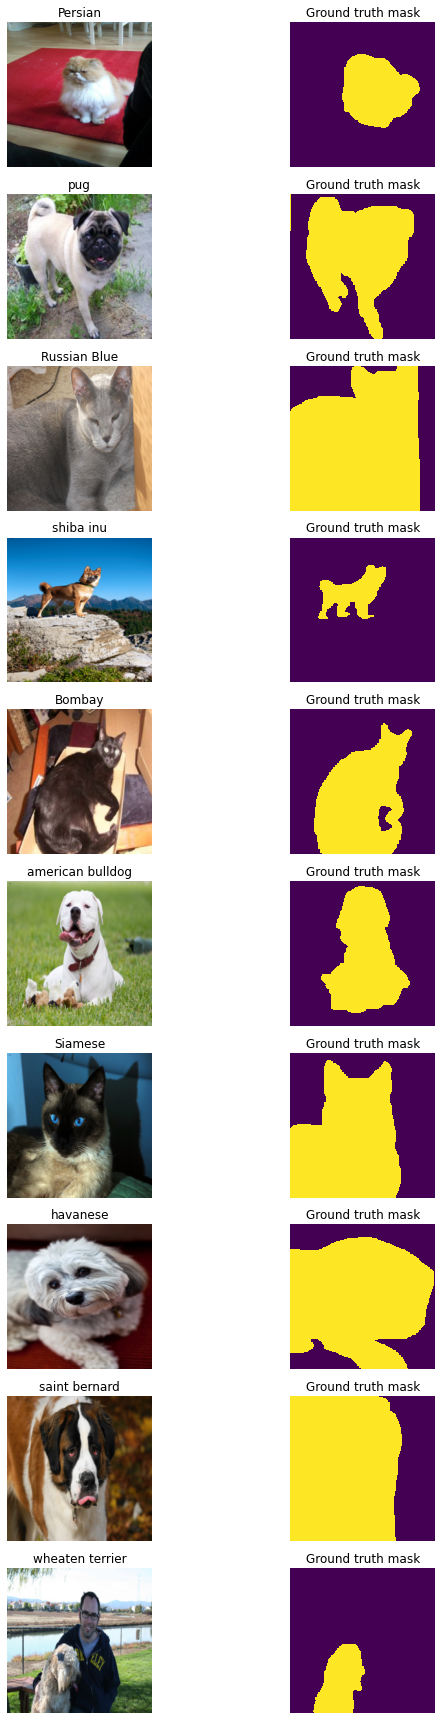

In [8]:
sample_loader = DataLoader(test_data, batch_size = 10, shuffle = True)
images, masks, labels = next(iter(sample_loader))

display_image_grid(images, masks, labels, 10)

## 2. Models
Load the 3 chosen models for your given task. Show the model's architecture.

#### Define functions for device and model loading:

 - FCN ResNet50
 - FCN ResNet101
 - DeepLabV3 ResNet101
 - LR-ASPP MobileNetV3-Large

In [9]:
# Device
def get_device():
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    return device

def get_fcn_resnet50():
    return models.segmentation.fcn_resnet50(pretrained=True).to(get_device())

def get_fcn_resnet101():
    return models.segmentation.fcn_resnet101(pretrained=True).to(get_device())

def get_lraspp_mobilenet_v3_large():
    return models.segmentation.lraspp_mobilenet_v3_large(pretrained=True).to(get_device())

def get_deeplabv3_resnet101():  
    return models.segmentation.deeplabv3_resnet101(pretrained=True).to(get_device())

### Question 1
Describe the main differences between the models you chose.



We have 4 models:
 - 2 model is a fully convolutional network. One has a 50 layers backbone, another has 101 layers backbone. Both has an FCNHead classifier.
 - LR-ASSP has a MobileNetV3-large backbone, which is 27% faster than V2, and a LRASPPHead classifier.
 - DeepLabV3 has a ResNet101 backbone and a DeepLabHead classifier which use atrous convolution operation in the layers.

#### Load the models
Show the architectures

In [10]:
# ADD YOUR CODE HERE

fcn_resnet50              = get_fcn_resnet50()
fcn_resnet101             = get_fcn_resnet101()
lraspp_mobilenet_v3_large = get_lraspp_mobilenet_v3_large()
deeplabv3_resnet101       = get_deeplabv3_resnet101()

ResNet50 architecture

In [11]:
print(fcn_resnet50)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

ResNet101 architecture

In [12]:
print(fcn_resnet101)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

DeepLabV3 ResNet101 arcitecture

In [13]:
print(deeplabv3_resnet101)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

LR-AASP architecture

In [14]:
print(lraspp_mobilenet_v3_large)

LRASPP(
  (backbone): IntermediateLayerGetter(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

## 3. Evaluation
This is the most important part. Please give a detailed comparison between the models.

**Implement your metrics manually**. Do not use pre defined Pytorch metrics.

Calculate the metrics for each model on the test set.

Plot the metrics.

Show some predictions in comparison to the ground truth.

#### Evaluate your models

The dataset contains pixel-level trimap segmentation. For each image, there is an associated PNG file with a mask. The size of a mask equals to the size of the related image. Each pixel in a mask image can take one of three values: 1, 2, or 3. 1 means that this pixel of an image belongs to the class pet, 2 - to the class background, 3 - to the class border. Since we want binary segmentation (that is assigning one of two classes to each pixel), we will preprocess the mask, so it will contain only two uniques values: 0 if a pixel is a background and 1 if a pixel is a pet or a border.

#### Function for predictions

In [15]:
def get_predictions(test_data, model):
    
    device = get_device()
    model  = model
    
    images_tensors = []
    gt_tensors     = []
    output_tensors = []
    test_labels    = []

    test_loader = DataLoader(test_data, batch_size = 150, shuffle = False)

    model.eval()
    for i, (images, masks, labels) in enumerate(test_loader):
        images = images.to(device)

        # Make the predictions for labels across the image
        with torch.no_grad():
            output = model(images)["out"]
            output = output.argmax(1)

        output   = output.cpu().numpy()
        
        images_tensors.append(images.cpu().numpy())
        gt_tensors.append(masks.numpy())
        output_tensors.append(output)
        test_labels.append(labels)
        
    images      = np.concatenate([images_tensors[0], images_tensors[1]], axis = 0)
    predictions = np.concatenate([output_tensors[0], output_tensors[1]], axis = 0)
    gt_masks    = np.concatenate([gt_tensors[0], gt_tensors[1]], axis = 0)
    test_labs   = np.concatenate([test_labels[0], test_labels[1]], axis = 0)

    for i in range(len(output_tensors)):
        
        images      = np.concatenate([images, images_tensors[i]], axis = 0)
        predictions = np.concatenate([predictions, output_tensors[i]], axis = 0)
        gt_masks    = np.concatenate([gt_masks, gt_tensors[i]], axis = 0)
        test_labs    = np.concatenate([test_labs, test_labels[i]], axis = 0)

        
    return images, gt_masks, predictions, test_labs

#### Function for metrics:
 The selected metrics are the following:
  - accuracy
  - recall
  - Dice score
  - IoU
  - Mean Dice score
  - Mean IoU score

In [16]:
def metrics(gt_masks, predictions):
    
    accuracies = []
    recalls    = []
    mean_Dice  = []
    mean_IoU   = []

    for i in range(predictions.shape[0]):

        Y_pred = predictions[i]
        Y_true = gt_masks[i]

        FP = len(np.where(Y_pred - Y_true == -1)[0])
        FN = len(np.where(Y_pred - Y_true == 1)[0])
        TP = len(np.where(Y_pred + Y_true == 2)[0])
        TN = len(np.where(Y_pred + Y_true == 0)[0])

        cmat = [[TP, FN],
                [FP, TN]]

        accuracy = (TP + TN) / (TP + TN + FP + FN)
        recall   = TP / (TP + FN + 1e-8)
        IoU      = TP / (TP + FP + FN)
        Dice     = (2 * TP) / (2 * TP + FP + FN)

        accuracies.append(accuracy)
        recalls.append(recall)
        mean_Dice.append(Dice)
        mean_IoU.append(IoU)
        
    accuracies = np.mean(np.array(accuracies))
    recalls    = np.mean(np.array(recalls))
    mean_Dice  = np.mean(np.array(mean_Dice))
    mean_IoU   = np.mean(np.array(mean_IoU))
    
    return accuracies, recalls, mean_Dice, mean_IoU

def dice_iou_new(gt_masks, predictions):
    num    = predictions.shape[0]
    inputs = predictions.reshape(num, -1)
    target = gt_masks.reshape(num, -1)

    intersection = (inputs * target).sum(1)
    union        = inputs.sum(1) + target.sum(1)
    dice         = (2. * intersection) / (union + 1e-8)
    dice         = dice.sum() / num
    IoU          = (intersection) / (union - intersection)
    IoU          = IoU.sum() / num

    print("Dice", dice)
    print("mean_IoU", IoU)
    
def show_confusion_mat(cmat):
    
    plt.figure(figsize = (6,6))
    sns.heatmap(cmat / np.sum(cmat), cmap = "Reds", annot = True, fmt = '.2%', square = 1,   linewidth = 2.)
    plt.xlabel("predictions")
    plt.ylabel("real values")
    plt.show()

### FCN ResNet50

#### Get the predictions for the mask and post-processing them:
 - Convert the categories from 8 and 12 (cat and dog category in the original model) to 0 and 1

In [17]:
# ADD YOUR CODE HERE

resnet50_images, resnet50_gt_masks, resnet50_predictions, resnet50_test_labels = get_predictions(test_data, fcn_resnet50)
resnet50_predictions                                                           = postprocess_predictions(resnet50_predictions)

print(resnet50_images.shape)
print(resnet50_gt_masks.shape)
print(resnet50_predictions.shape)
print(resnet50_test_labels.shape)

(1520, 3, 224, 224)
(1520, 224, 224)
(1520, 224, 224)
(1520,)


#### Show the metrics results

In [18]:
# ADD YOUR CODE HERE

resnet50_accuracies, resnet50_recalls, resnet50_mean_Dice, resnet50_mean_IoU = metrics(resnet50_gt_masks, resnet50_predictions)

print(f'ResNet50: Accuracy- {resnet50_accuracies * 100}, Recall- {resnet50_recalls * 100}, Mean Dice- {resnet50_mean_Dice * 100}, Mean IoU- {resnet50_mean_IoU * 100}')

ResNet50: Accuracy- 92.5855711579451, Recall- 97.13231543868139, Mean Dice- 87.53508725618408, Mean IoU- 79.93865428731209


### FCN ResNet100

In [19]:
resnet101_images, resnet101_gt_masks, resnet101_predictions, resnet101_test_labels = get_predictions(test_data, fcn_resnet101)
resnet101_predictions                                                              = postprocess_predictions(resnet101_predictions)

In [20]:
resnet101_accuracies, resnet101_recalls, resnet101_mean_Dice, resnet101_mean_IoU = metrics(resnet101_gt_masks, resnet101_predictions)

print(f'ResNet100: Accuracy- {resnet101_accuracies * 100}, Recall- {resnet101_recalls * 100}, Mean Dice- {resnet101_mean_Dice * 100}, Mean IoU- {resnet101_mean_IoU * 100}')

ResNet100: Accuracy- 93.17974676507114, Recall- 97.28991500986592, Mean Dice- 88.41520279691301, Mean IoU- 81.14196338788418


### DeepLabV3

In [21]:
deeplabv3_images, deeplabv3_gt_masks, deeplabv3_predictions, deeplabv3_test_labels = get_predictions(test_data, deeplabv3_resnet101)
deeplabv3_predictions                                                              = postprocess_predictions(deeplabv3_predictions)

In [22]:
deeplabv3_accuracies, deeplabv3_recalls, deeplabv3_mean_Dice, deeplabv3_mean_IoU = metrics(deeplabv3_gt_masks, deeplabv3_predictions)

print(f'DeepLabV3: Accuracy- {deeplabv3_accuracies * 100}, Recall- {deeplabv3_recalls * 100}, Mean Dice- {deeplabv3_mean_Dice * 100}, Mean IoU- {deeplabv3_mean_IoU * 100}')

DeepLabV3: Accuracy- 93.20817564279001, Recall- 97.01319310627127, Mean Dice- 88.63808146106108, Mean IoU- 81.54048382220962


### LR-AASP

In [23]:
lr_aasp_images, lr_aasp_gt_masks, lr_aasp_predictions, lr_aasp_test_labels = get_predictions(test_data, lraspp_mobilenet_v3_large)
lr_aasp_predictions                                                        = postprocess_predictions(lr_aasp_predictions)

In [24]:
lr_aasp_accuracies, lr_aasp_recalls, lr_aasp_mean_Dice, lr_aasp_mean_IoU = metrics(lr_aasp_gt_masks, lr_aasp_predictions)

print(f'LR-AASP: Accuracy- {lr_aasp_accuracies * 100}, Recall- {lr_aasp_recalls * 100}, Mean Dice- {lr_aasp_mean_Dice * 100}, Mean IoU- {lr_aasp_mean_IoU * 100}')

LR-AASP: Accuracy- 87.05612428462338, Recall- 91.2743319424294, Mean Dice- 71.91772213803618, Mean IoU- 63.15058787813547


In [25]:
print(resnet101_accuracies * 100 - resnet50_accuracies * 100)
print(resnet101_recalls * 100 - resnet50_recalls * 100)
print(resnet101_mean_Dice * 100 - resnet50_mean_Dice * 100)
print(resnet101_mean_IoU * 100 - resnet50_mean_IoU * 100)

0.5941756071260471
0.15759957118453372
0.880115540728923
1.2033091005720848


Displaying the metrics results

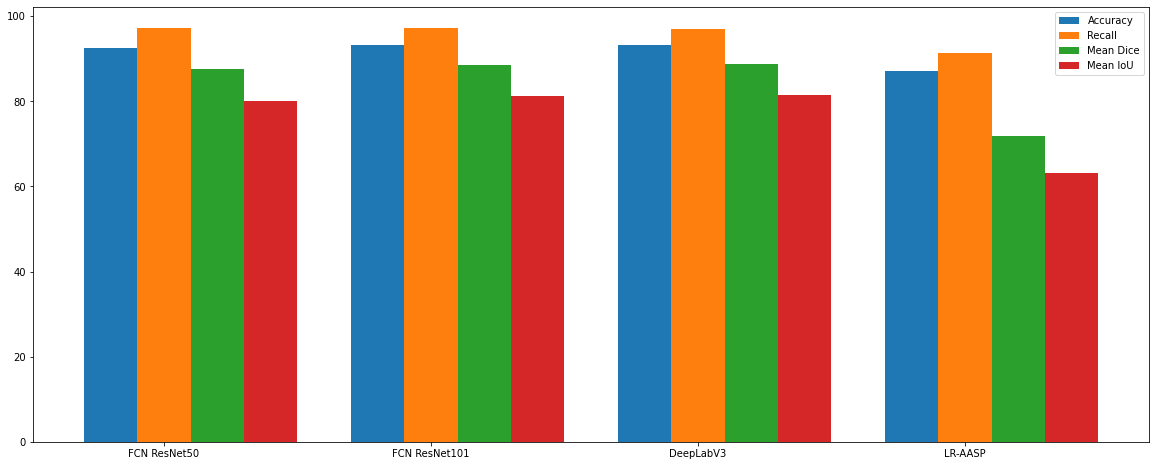

In [26]:

# Define Data
plt.rcParams["figure.figsize"] = (20,8)

models     = ['FCN ResNet50','FCN ResNet101','DeepLabV3','LR-AASP']
model_acc  = [resnet50_accuracies * 100, resnet101_accuracies * 100, deeplabv3_accuracies * 100, lr_aasp_accuracies * 100]
model_rec  = [resnet50_recalls * 100, resnet101_recalls * 100, deeplabv3_recalls * 100, lr_aasp_recalls * 100]
model_dice = [resnet50_mean_Dice * 100, resnet101_mean_Dice * 100, deeplabv3_mean_Dice * 100, lr_aasp_mean_Dice * 100]
model_iou  = [resnet50_mean_IoU * 100, resnet101_mean_IoU * 100, deeplabv3_mean_IoU * 100, lr_aasp_mean_IoU * 100]


x_axis = np.arange(len(models))

# Multi bar Chart

plt.bar(x_axis -0.2, model_acc, width=0.2, label = 'Accuracy')
plt.bar(x_axis +0.0, model_rec, width=0.2, label = 'Recall')
plt.bar(x_axis +0.2, model_dice, width=0.2, label = 'Mean Dice')
plt.bar(x_axis +0.4, model_iou, width=0.2, label = 'Mean IoU')

# Xticks
plt.xticks(x_axis, models)

# Add legend
plt.legend()

# Display
plt.show()

#### Show some predictions

Original resized image - Grand truth mask - Predicted mask

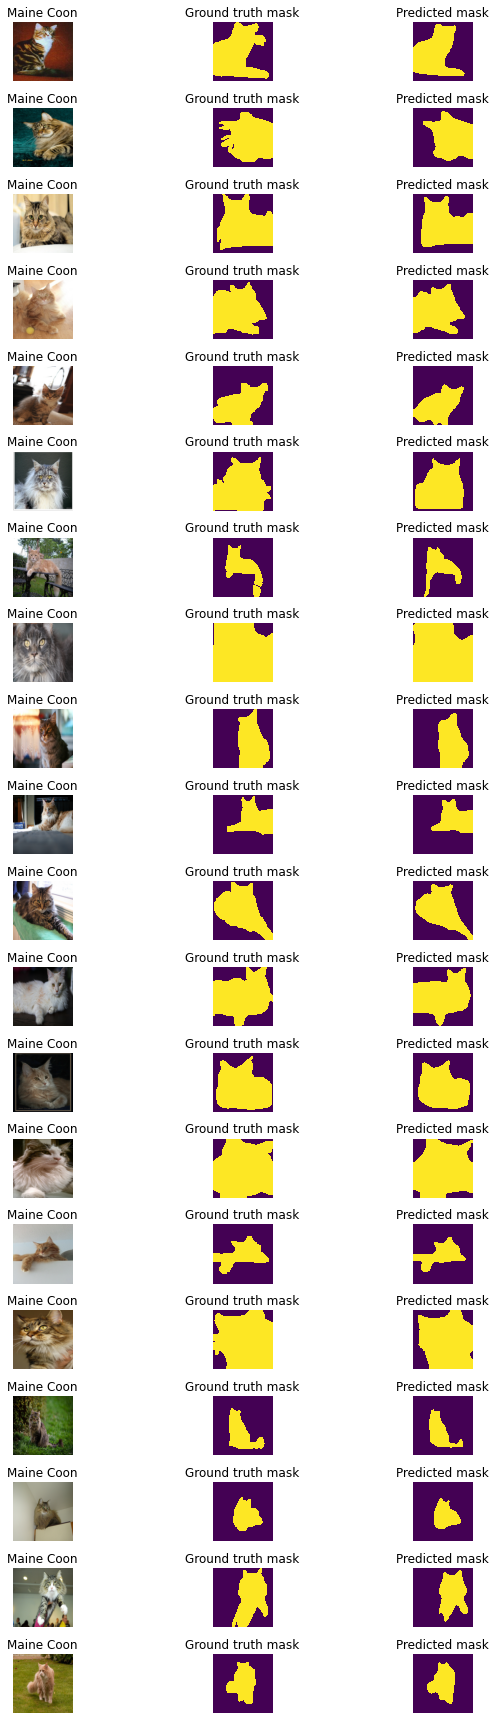

In [27]:
# ADD YOUR CODE HERE

display_image_grid(torch.from_numpy(deeplabv3_images),
                   deeplabv3_gt_masks,
                   deeplabv3_test_labels,
                   20,
                   deeplabv3_predictions)

## 4. Conclusion

### Answer the questions
#### Question 2. 
Which model performed the best? Why do you think it performed better than others?

#### Question 3. 
How could you improve the performance of the models?

Question 2:

The most relevant metrics are Mean Dice and Mean IoU. The best model was FCN ResNet101. The second best was FCN ResNet50. You can see the differences to ResNet50 below:

- Accuracy: 0.5941756071260471
- Recall: 0.15759957118453372
- Mean Dice: 0.880115540728923
- Mean IoU: 1.2033091005720848

Maybe the reason for that is ResNet101 has more layers.

Question 3.:

Because these are pre-trained models and they have been trained on a subset of COCO train2017, on the 20 categories that are present in the Pascal VOC dataset, therefore in order to get a better model we have to use transfer learning and fine-tuning the model on the current dataset.